In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from generator.datamodule import *

[2023-10-11 21:38:01,742] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [20]:
from transformers import AutoTokenizer, ByT5Tokenizer

In [21]:
t = ByT5Tokenizer()

In [22]:
t.vocab_size

256

In [2]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("kaiyuy/leandojo-lean3-tacgen-byt5-small")
model = AutoModelForSeq2SeqLM.from_pretrained("kaiyuy/leandojo-lean3-tacgen-byt5-small", device_map="auto")

In [5]:
type(model)

transformers.models.t5.modeling_t5.T5ForConditionalGeneration

In [6]:
type(model.encoder)

transformers.models.t5.modeling_t5.T5Stack

In [3]:
state = "n : ℕ\n⊢ gcd n n = n"
tokenized_state = tokenizer(state, return_tensors="pt")

In [5]:
model.encoder(tokenized_state.input_ids)['last_hidden_state'].shape

torch.Size([1, 24, 1472])

In [8]:
tactic_candidates_ids = model.generate(
    tokenized_state.input_ids,
    max_length=1024,
    num_beams=4,
    length_penalty=0.0,
    do_sample=False,
    num_return_sequences=4,
    early_stopping=False,
)
tactic_candidates = tokenizer.batch_decode(
    tactic_candidates_ids, skip_special_tokens=True
)
for tac in tactic_candidates:
    print(tac)

simp [<a>nat.gcd</a>]
unfold gcd
rw [<a>nat.gcd_comm</a>]
rw [<a>nat.gcd</a>, <a>nat.gcd_self_right</a>]


In [ ]:
tactic_candidates_ids = model.generate(
    encoder_outputs=model.encoder(tokenized_state.input_ids),
    max_length=1024,
    num_beams=4,
    length_penalty=0.0,
    do_sample=False,
    num_return_sequences=4,
    early_stopping=False,
)
tactic_candidates = tokenizer.batch_decode(
    tactic_candidates_ids, skip_special_tokens=True
)
for tac in tactic_candidates:
    print(tac)

In [11]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, T5ForConditionalGeneration

tokenizer = AutoTokenizer.from_pretrained("kaiyuy/leandojo-lean3-retriever-tacgen-byt5-small")
model = T5ForConditionalGeneration.from_pretrained("kaiyuy/leandojo-lean3-retriever-tacgen-byt5-small")

state = "n : ℕ\n⊢ gcd n n = n"
retrieved_premises = [
  "def <a>nat.gcd</a> : nat → nat → nat\n| 0        y := y\n| (succ x) y := have y % succ x < succ x, from mod_lt _ $ succ_pos _,\n                gcd (y % succ x) (succ x)",
  "@[simp] theorem <a>nat.mod_self</a> (n : nat) : n % n = 0",
]
input = "\n\n".join(retrieved_premises + [state])
print("------ INPUT ------\n", input)
tokenized_input = tokenizer(input, return_tensors="pt", max_length=2300, truncation=True)

# Loss
labels = tokenizer("cases n", return_tensors="pt", max_length=2300, truncation=True).input_ids
print(tokenized_input.attention_mask.shape)
print(tokenized_input.input_ids.shape)
print(labels.shape)
print(model(tokenized_input.input_ids, tokenized_input.attention_mask, labels=labels).loss)

# Generate a single tactic.
tactic_ids = model.generate(tokenized_input.input_ids, max_length=1024)
tactic = tokenizer.decode(tactic_ids[0], skip_special_tokens=True)
print("\n------ OUTPUT ------")
print(tactic, end="\n\n")

# Generate multiple tactics via beam search.
tactic_candidates_ids = model.generate(
    tokenized_input.input_ids,
    max_length=1024,
    num_beams=4,
    length_penalty=0.0,
    do_sample=False,
    num_return_sequences=4,
    early_stopping=False,
)
tactic_candidates = tokenizer.batch_decode(
    tactic_candidates_ids, skip_special_tokens=True
)
for tac in tactic_candidates:
    print(tac)

------ INPUT ------
 def <a>nat.gcd</a> : nat → nat → nat
| 0        y := y
| (succ x) y := have y % succ x < succ x, from mod_lt _ $ succ_pos _,
                gcd (y % succ x) (succ x)

@[simp] theorem <a>nat.mod_self</a> (n : nat) : n % n = 0

n : ℕ
⊢ gcd n n = n
torch.Size([1, 255])
torch.Size([1, 255])
torch.Size([1, 8])
tensor(0.1879, grad_fn=<NllLossBackward0>)

------ OUTPUT ------
cases n

cases n
simp [<a>nat.gcd</a>]
induction n with n ih
induction n with n IH


### RMT debug

In [1]:
from generator.datamodule import MultipleSegmentGeneratorDataModule
from generator.model import RMTRetrievalAugmentedGenerator
import lightning_fabric.utilities.seed

lightning_fabric.utilities.seed.seed_everything(42)

num_memory_tokens = 10

[2023-11-02 17:45:09,655] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


Global seed set to 42


In [2]:
data = MultipleSegmentGeneratorDataModule(
    model_name="kaiyuy/leandojo-lean3-retriever-tacgen-byt5-small",
    data_path="data/leandojo_benchmark/random/",
    corpus_path="data/leandojo_benchmark/corpus.jsonl",
    keep_marks=True,
    preds_path="pred_random.pickle",
    batch_size=8,  # effective_batch_size == batch_size * accumulate_grad_batches * devices
    eval_batch_size=64,
    max_seq_len=2300 - 2 * num_memory_tokens,
    num_segments=2,
    p_drop=0.5,
    normalize_tactics=True,
    num_workers=2,
    p_only_memory=0.8,
)
data.setup()

train_dataloader = data.train_dataloader()

2023-11-02 17:45:10.040 | INFO     | common:__init__:200 - Building the corpus from data/leandojo_benchmark/corpus.jsonl
2023-11-02 17:45:21.674 | INFO     | generator.datamodule:__init__:357 - With retrieval data
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94641/94641 [00:02<00:00, 34367.33it/s]
2023-11-02 17:46:00.960 | INFO     | generator.datamodule:_load_data:69 - 207631 examples loaded
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 28989.71it/s]
2023-11-02 17:46:01.121 | INFO     | generator.datamodule:_load_data:69 - 4866 examples loaded


In [3]:
# model = RMTRetrievalAugmentedGenerator(
#     backbone_model_name="kaiyuy/leandojo-lean3-retriever-tacgen-byt5-small",
#     num_memory_tokens=num_memory_tokens,
#     lr=5e-4,
#     warmup_steps=2000,
#     num_beams=1,
#     length_penalty=0.0,
#     ret_ckpt_path="../leandojo-pl-ckpts/retriever_random.ckpt",
#     eval_num_retrieved=100,
#     eval_num_cpus=12,
#     eval_num_theorems=200,
#     max_seq_len=2300,
#     num_segments=2,
# )

model = RMTRetrievalAugmentedGenerator.load("./leandojo_rmt/ts6m2dih/checkpoints/epoch=4-step=217628.ckpt", device="cpu",  freeze=True)

Processing zero checkpoint './leandojo_rmt/ts6m2dih/checkpoints/epoch=3-step=170721.ckpt/checkpoint'
Detected checkpoint of type zero stage 2, world_size: 1
Parsing checkpoint created by deepspeed==0.11.1
Reconstructed Frozen fp32 state dict with 111 params 217657472 elements
Reconstructed fp32 state dict with 170 params 299637760 elements
Saving fp32 state dict to /tmp/tmpejfanf8k/lightning.cpkt


2023-10-27 23:44:07.703 | INFO     | generator.model:__init__:110 - Loading the retriever from ../leandojo-pl-ckpts/retriever_random.ckpt


Processing zero checkpoint '../leandojo-pl-ckpts/retriever_random.ckpt/checkpoint'
Detected checkpoint of type zero stage 2, world_size: 1
Parsing checkpoint created by deepspeed==0.9.2
Reconstructed fp32 state dict with 111 params 217657472 elements
Saving fp32 state dict to /tmp/tmpn53nku3p/lightning.cpkt


/home/nesterov-va/lean_dojo/lean_dojo_env/lib/python3.10/site-packages/pytorch_lightning/core/saving.py:161: UserWarning: Found keys that are in the model state dict but not in the checkpoint: ['encoder.encoder.embed_tokens.weight']
  rank_zero_warn(


In [4]:
ex = None
for t in train_dataloader:
    ex = t
    break

In [5]:
len(ex['state_ids'])

2

In [14]:
len(ex['state_ids'][0])

8

In [7]:
ex['state_ids'][0][0].shape

torch.Size([2279])

In [10]:
print(data.ds_train[0]['state'][1])

α : Type u_1,
_inst_1 : linear_order α,
E : Type u_3,
_inst_3 : pseudo_emetric_space E,
f : α → E,
s : set α,
a : α
⊢ variation_on_from_to f s a a = 0


In [11]:
print(model.tokenizer.decode(ex['state_ids'][0][0]))

@[simp, mfld_simps]
theorem <a>set.mem_inter_iff</a> (x : α) (a b : set α) : x ∈ a ∩ b ↔ (x ∈ a ∧ x ∈ b)

lemma <a>filter.mem_comap'</a> : s ∈ comap f l ↔ {y | ∀ ⦃x⦄, f x = y → x ∈ s} ∈ l

theorem <a>set.set_of_forall</a> (p : ι → β → Prop) : {x | ∀ i, p i x} = ⋂ i, {x | p i x}

@[simp] theorem <a>not_and</a> : ¬ (a ∧ b) ↔ (a → ¬ b)

@[simp] lemma <a>iff_self</a> (a : Prop) : (a ↔ a) ↔ true

protected def <a>set.infinite</a> (s : set α) : Prop := ¬ s.finite

theorem <a>filter.limsup_le_of_le</a> {f : filter β} {u : β → α} {a}
  (hf : f.is_cobounded_under (≤) u. is_bounded_default) (h : ∀ᶠ n in f, u n ≤ a) :
  limsup u f ≤ a

@[simp] theorem <a>set.mem_sep_iff</a> : x ∈ {x ∈ s | p x} ↔ x ∈ s ∧ p x

@[simp] lemma <a>filter.limsup_nat_add</a> (f : ℕ → α) (k : ℕ) :
  limsup (λ i, f (i + k)) at_top = limsup f at_top

lemma <a>set.compl_def</a> (s : set α) : sᶜ = {x | x ∉ s}

protected def <a>filter.eventually</a> (p : α → Prop) (f : filter α) : Prop := {x | p x} ∈ f

theorem <a>filter.limsu

In [12]:
print(model.tokenizer.decode(ex['state_ids'][1][0]))

α : Type u_1,
ι : Type u_4,
s : ι → set α
⊢ limsup s cofinite = {x : α | {n : ι | x ∈ s n}.infinite}</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><

In [13]:
print(model.tokenizer.decode(ex['tactic_ids'][0][:70]))

simp only [← cofinite.blimsup_true s, <a>filter.cofinite.blimsup_set


In [17]:
model.forward(
    ex["state_ids"],
    ex["state_mask"],
    ex["tactic_ids"],
)

torch.Size([8, 2275]) torch.Size([8, 20, 1472])
tensor(13.1288, grad_fn=<LinalgVectorNormBackward0>)
tensor(13.1288, grad_fn=<LinalgVectorNormBackward0>)


tensor(1.2409, grad_fn=<NllLossBackward0>)

In [6]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tactic_candidates_ids = model.generate(
    state="i : int\n⊢ gcd i i = nat_abs i",
    file_path="src/data/int/gcd.lean",
    theorem_full_name="int.gcd_self",
    theorem_pos=(195,1),
    num_samples=4,
)
tactic_candidates = tokenizer.batch_decode(
    tactic_candidates_ids, skip_special_tokens=True
)
for tac in tactic_candidates:
    print(tac)

2023-10-23 13:52:39.736 | INFO     | retrieval.model:reindex_corpus:172 - Re-indexing the retrieval corpus


AttributeError: 'PremiseRetriever' object has no attribute 'corpus'

In [7]:
type(model)

generator.model.RMTRetrievalAugmentedGenerator

In [11]:
type(data.preds)

dict

In [9]:
key = list(data.preds.keys())[0]
print(key)
prem = data.preds[key]['retrieved_premises'][0]

('src/analysis/bounded_variation.lean', 'variation_on_from_to.self', 'α : Type u_1,\n_inst_1 : linear_order α,\nE : Type u_3,\n_inst_3 : pseudo_emetric_space E,\nf : α → E,\ns : set α,\na : α\n⊢ variation_on_from_to f s a a = 0')


In [11]:
prem.start

(737, 1)

In [22]:
data.ds_train[4]

{'url': 'https://github.com/leanprover-community/mathlib',
 'commit': '32a7e535287f9c73f2e4d2aef306a39190f0b504',
 'file_path': 'src/analysis/calculus/diff_cont_on_cl.lean',
 'full_name': 'diff_cont_on_cl.continuous_on_ball',
 'state': ["def <a>metric.ball</a> (x : α) (ε : ℝ) : set α := {y | dist y x < ε}\n\nlemma <a>balanced_ball_zero</a> : balanced 𝕜 (metric.ball (0 : E) r)\n\n@[simp] theorem <a>metric.closed_ball_diff_sphere</a> : closed_ball x ε \\ sphere x ε = ball x ε\n\ndef <a>metric.sphere</a> (x : α) (ε : ℝ) := {y | dist y x = ε}\n\ntheorem <a>int.preimage_closed_ball</a> (x : ℤ) (r : ℝ) :\n  coe ⁻¹' (closed_ball (x : ℝ) r) = closed_ball x r\n\nlemma <a>metric.closed_ball_eq_bInter_ball</a> : closed_ball x ε = ⋂ δ > ε, ball x δ\n\nlemma <a>real.closed_ball_eq_Icc</a> {x r : ℝ} : closed_ball x r = Icc (x - r) (x + r)\n\ntheorem <a>metric.closed_ball_eq_sphere_of_nonpos</a> (hε : ε ≤ 0) : closed_ball x ε = sphere x ε\n\nlemma <a>seminorm.preimage_metric_closed_ball</a> {r : ℝ} :

In [7]:
import torch

In [40]:
input_ids = torch.arange(5).unsqueeze(0)
labels = torch.arange(5, 12).unsqueeze(0)
attention_mask = torch.ones(5)
attention_mask[[0, 2, 4]] = 0
attention_mask = attention_mask.unsqueeze(0)

In [41]:
out = model.generator.forward(
    input_ids=input_ids,
    attention_mask=attention_mask,
    labels=labels,
    #output_hidden_states=True,
)

In [42]:
out.loss

tensor(105.0325, grad_fn=<NllLossBackward0>)

In [39]:
out.keys()

odict_keys(['loss', 'logits', 'past_key_values', 'decoder_hidden_states', 'encoder_last_hidden_state', 'encoder_hidden_states'])

In [44]:
out = model.generator.forward(
    encoder_outputs=(enc_out,),
    attention_mask=attention_mask,
    labels=labels
)

In [45]:
out.loss

tensor(105.0325, grad_fn=<NllLossBackward0>)

In [8]:
import torch
a = torch.tensor([0, 1], dtype=torch.float, requires_grad=True)
b = torch.zeros(2)

In [10]:
torch.cat([a, b])

tensor([0., 1., 0., 0.], grad_fn=<CatBackward0>)

In [11]:
a

tensor([0., 1.], requires_grad=True)

## Attention of the original model

In [27]:
from generator.datamodule import GeneratorDataModule
from generator.model import RetrievalAugmentedGenerator
import lightning_fabric.utilities.seed

lightning_fabric.utilities.seed.seed_everything(42)

Global seed set to 42


42

In [28]:
data = GeneratorDataModule(
    model_name="kaiyuy/leandojo-lean3-retriever-tacgen-byt5-small",
    data_path="data/leandojo_benchmark/random/",
    corpus_path="data/leandojo_benchmark/corpus.jsonl",
    keep_marks=True,
    preds_path="pred_random.pickle",
    batch_size=1,  # effective_batch_size == batch_size * accumulate_grad_batches * devices
    eval_batch_size=64,
    max_seq_len=2300,
    p_drop=0.5,
    normalize_tactics=True,
    num_workers=2,
)
data.setup()

train_dataloader = data.train_dataloader()

2023-10-23 10:42:30.989 | INFO     | common:__init__:200 - Building the corpus from data/leandojo_benchmark/corpus.jsonl
2023-10-23 10:42:51.347 | INFO     | generator.datamodule:__init__:162 - With retrieval data
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94641/94641 [00:02<00:00, 40064.22it/s]
2023-10-23 10:43:29.661 | INFO     | generator.datamodule:_load_data:68 - 207631 examples loaded
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 30832.31it/s]
2023-10-23 10:43:29.823 | INFO     | generator.datamodule:_load_data:68 - 4866 examples loaded


In [29]:
model = RetrievalAugmentedGenerator(
    model_name="kaiyuy/leandojo-lean3-retriever-tacgen-byt5-small",
    lr=5e-4,
    warmup_steps=2000,
    num_beams=1,
    length_penalty=0.0,
    ret_ckpt_path="../leandojo-pl-ckpts/retriever_random.ckpt",
    eval_num_retrieved=100,
    eval_num_cpus=12,
    eval_num_theorems=200,
    max_seq_len=2300,
)

2023-10-23 10:43:31.825 | INFO     | generator.model:__init__:110 - Loading the retriever from ../leandojo-pl-ckpts/retriever_random.ckpt


Processing zero checkpoint '../leandojo-pl-ckpts/retriever_random.ckpt/checkpoint'
Detected checkpoint of type zero stage 2, world_size: 1
Parsing checkpoint created by deepspeed==0.9.2
Reconstructed fp32 state dict with 111 params 217657472 elements
Saving fp32 state dict to /tmp/tmpxcfpmd6x/lightning.cpkt


In [50]:
# extract examples' ids
N_EXAMPLES = 8
examples = []

for i, t in zip(range(N_EXAMPLES), train_dataloader):
    examples.append(t)

print(len(examples))
print(examples[0].keys())
print(examples[0]['state_ids'].shape)
print(examples[0]['tactic_ids'].shape)

# run model to get attentions
cross_attentions = []
encoder_attentions = []
for ex in examples:
    out = model.generator(
        input_ids=ex['state_ids'],
        attention_mask=ex['state_mask'],
        labels=ex['tactic_ids'],
        output_attentions=True,
    )
    encoder_attentions.append([x[0] for x in out.encoder_attentions])
    cross_attentions.append([x[0] for x in out.cross_attentions])

print(len(encoder_attentions[0]), encoder_attentions[0][0].shape)
print(len(cross_attentions[0]), cross_attentions[0][0].shape)

8
dict_keys(['state', 'state_ids', 'state_mask', 'tactic', 'tactic_ids', 'tactic_mask', 'url', 'commit', 'file_path', 'full_name'])
torch.Size([1, 2277])
torch.Size([1, 5])
12 torch.Size([6, 2277, 2277])
4 torch.Size([6, 5, 2277])


In [64]:
example = 1
print('---STATE---')
print(examples[example]['state'][0])
print('---TACTIC---')
print(examples[example]['tactic'][0])

---STATE---
lemma <a>affine_basis.tot</a> : affine_span k (range b) = ⊤

@[simp] lemma <a>submodule.comap_top</a> (f : F) : comap f ⊤ = ⊤

@[simp, norm_cast] lemma <a>lower_set.coe_top</a> : ((⊤ : lower_set α) : set α) = univ

@[simp, to_additive] lemma <a>subgroup.coe_top</a> : ((⊤ : subgroup G) : set G) = set.univ

lemma <a>submodule.eq_top_iff'</a> {p : submodule R M} : p = ⊤ ↔ ∀ x, x ∈ p

theorem <a>ideal.map_top</a> : map f ⊤ = ⊤

theorem <a>polynomial.splitting_field.adjoin_root_set</a> : algebra.adjoin K (f.root_set (splitting_field f)) = ⊤

@[simp] lemma <a>subsemiring.coe_top</a> : ((⊤ : subsemiring R) : set R) = set.univ

@[simp] theorem <a>algebra.map_top</a> (f : A →ₐ[R] B) : (⊤ : subalgebra R A).map f = f.range

@[simp] lemma <a>set.top_eq_univ</a> : (⊤ : set α) = univ

theorem <a>measure_theory.outer_measure.map_top_of_surjective</a> (f : α → β) (hf : surjective f) : map f ⊤ = ⊤

@[simp] lemma <a>star_subalgebra.top_to_subalgebra</a> : (⊤ : star_subalgebra R A).to_subalge

In [34]:
def find_lemma_tags(ids):
    '''
    Find all <a> positions in ids
    '''
    ans = []
    for i in range(len(ids)):
        if ids[i:i+3] == [63, 100, 65]:
            ans.append(i)
    return ans

In [39]:
cross_attentions[0][0].shape

torch.Size([6, 54, 2287])

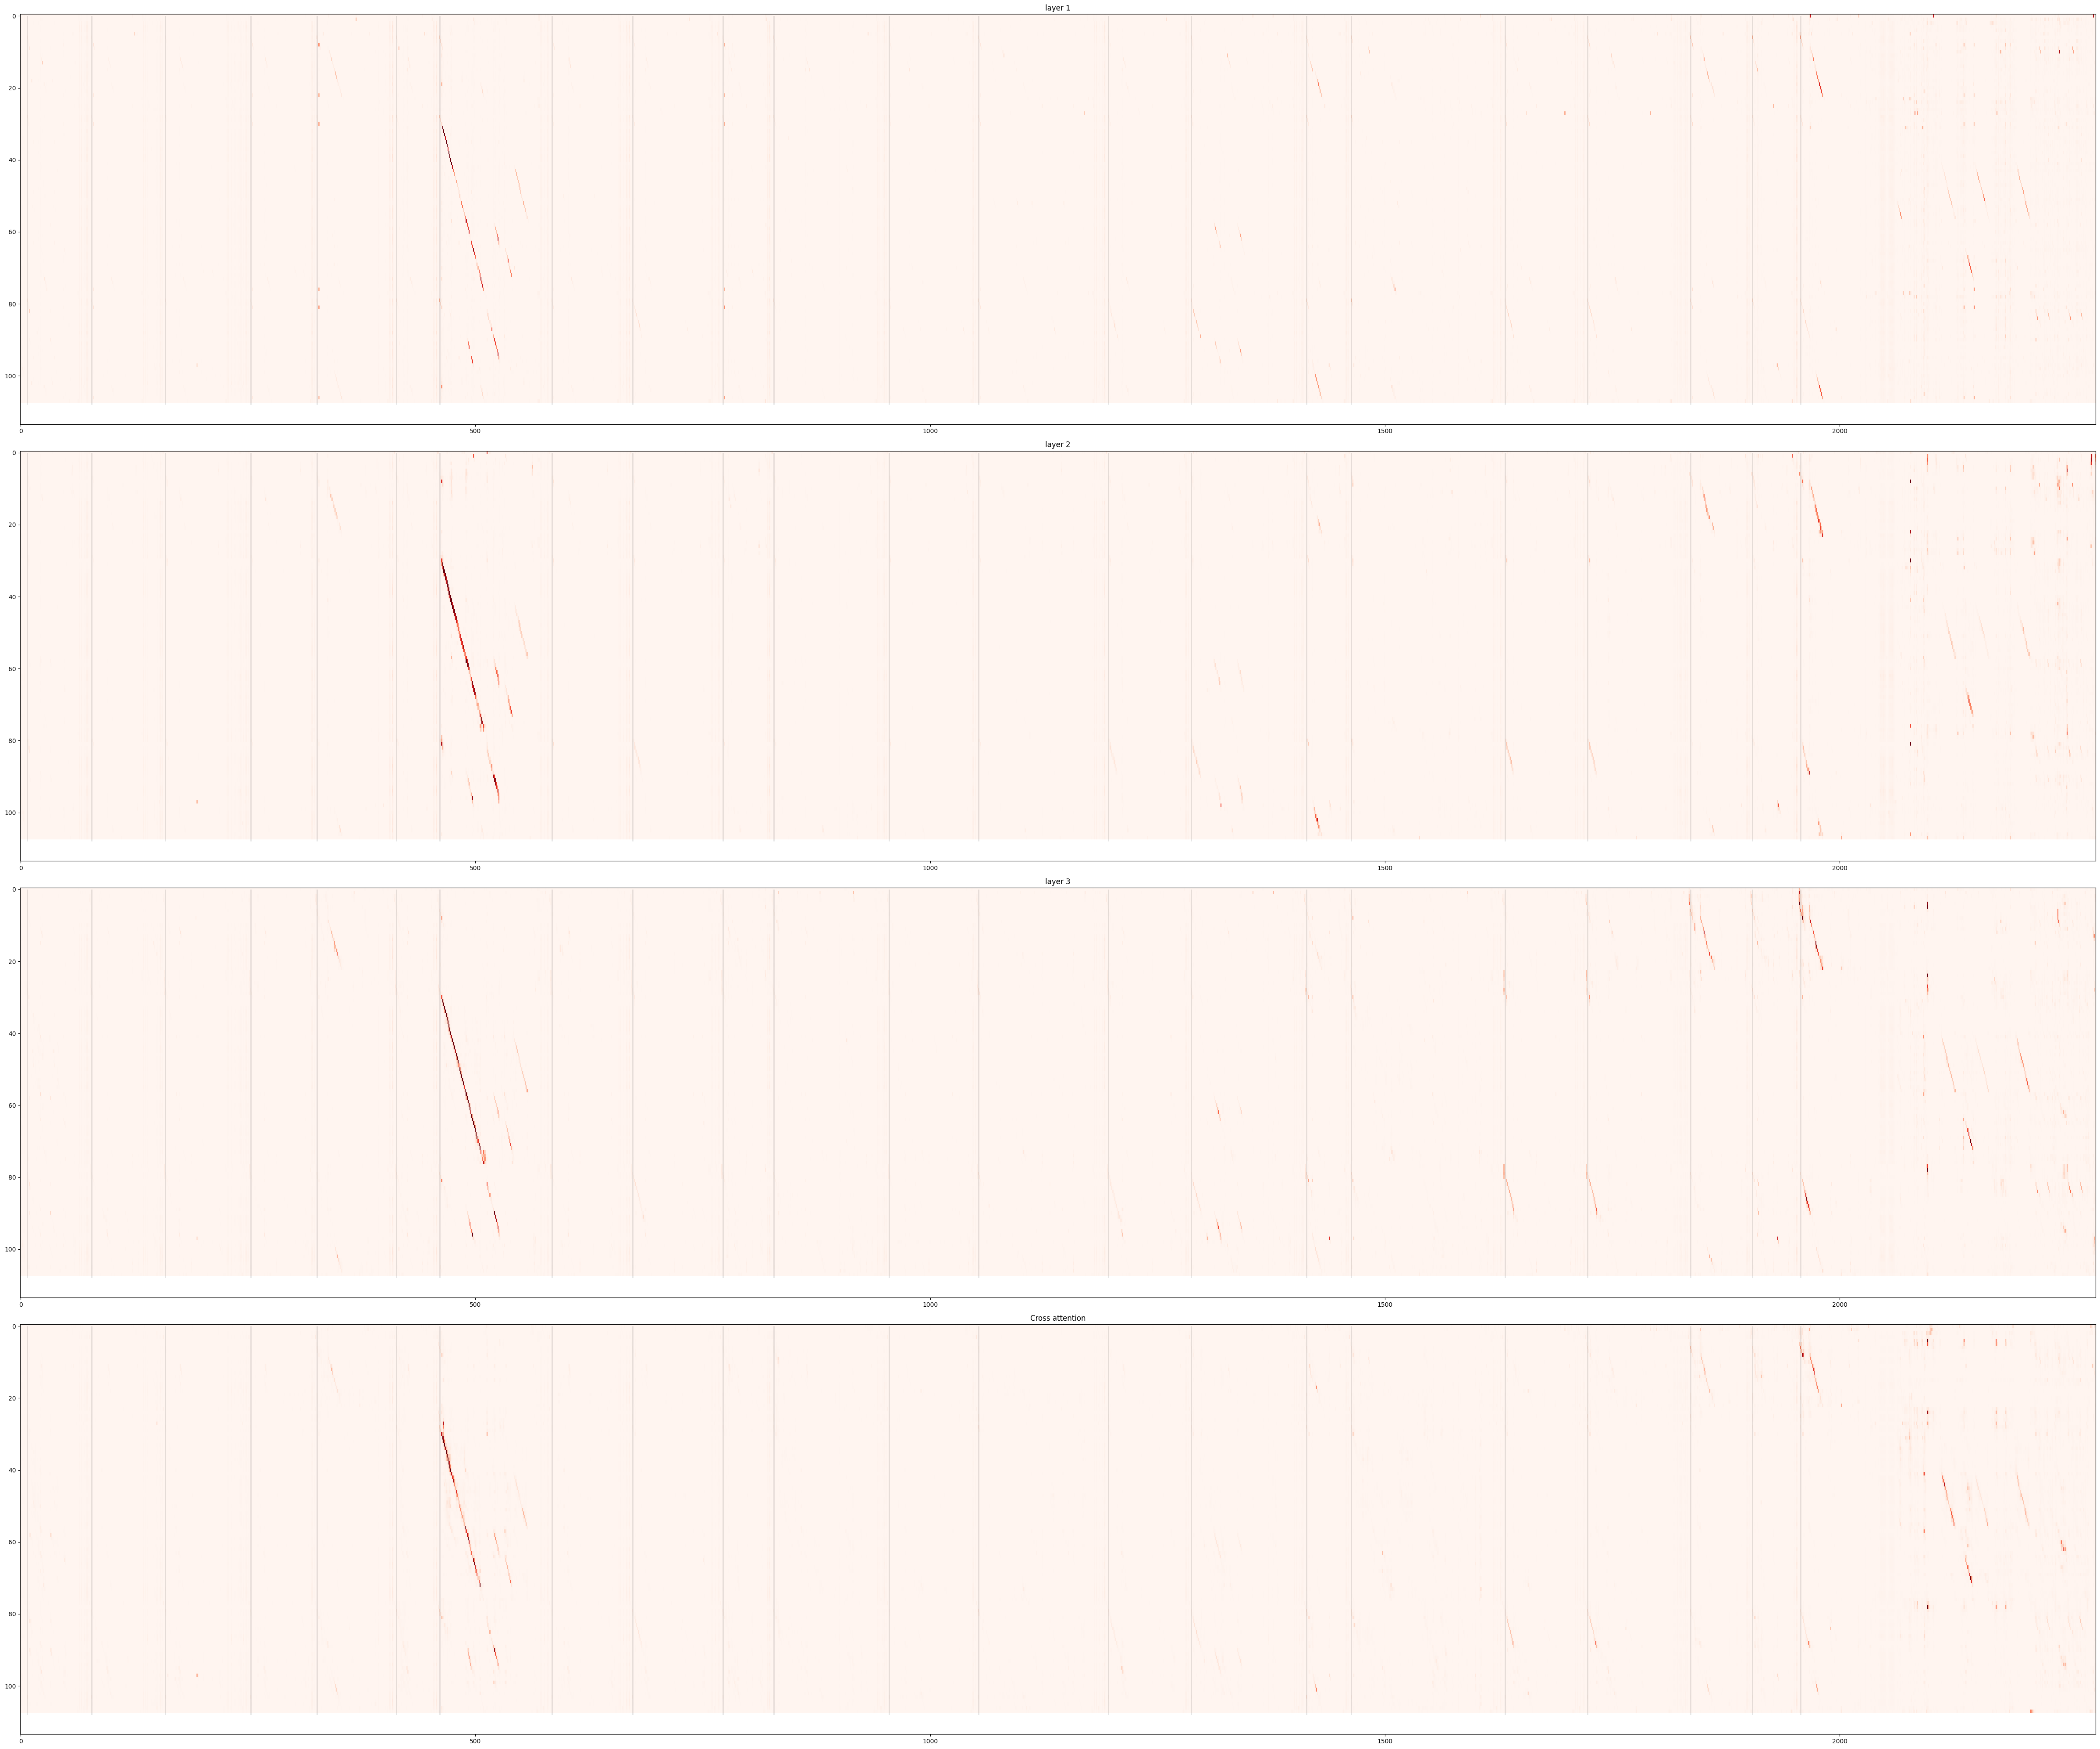

In [66]:
from matplotlib import pyplot as plt

layers = 4
example = 1

fig, axs = plt.subplots(layers, 1, figsize=(12 * layers, 40))
for layer in range(layers):
    #idx = layer * heads + head
    idx = layer
    axs[idx].set_title(f"layer {layer + 1}")
    #N = (sequences[example][segment]['attention_mask'][0] == 1).sum() + 20
    im = axs[idx].imshow(cross_attentions[example][layer].sum(dim=0).detach().cpu().float(), 
                      vmin=0, vmax=1, cmap=plt.cm.Reds, aspect='auto', interpolation='none')
    lemmas_idxes = find_lemma_tags(list(examples[example]['state_ids'][0]))
    lemmas_idxes = [x + 1 for x in lemmas_idxes] # +10 by memory and +2 because "<lemma>" takes 4 tokens
    for lemma_idx in lemmas_idxes:
        axs[idx].vlines(x = lemma_idx, ymin=0, ymax=cross_attentions[example][layer].shape[1], color = 'black', linewidths=(2,), alpha=0.1)

plt.title("Cross attention")
plt.tight_layout()
plt.show()

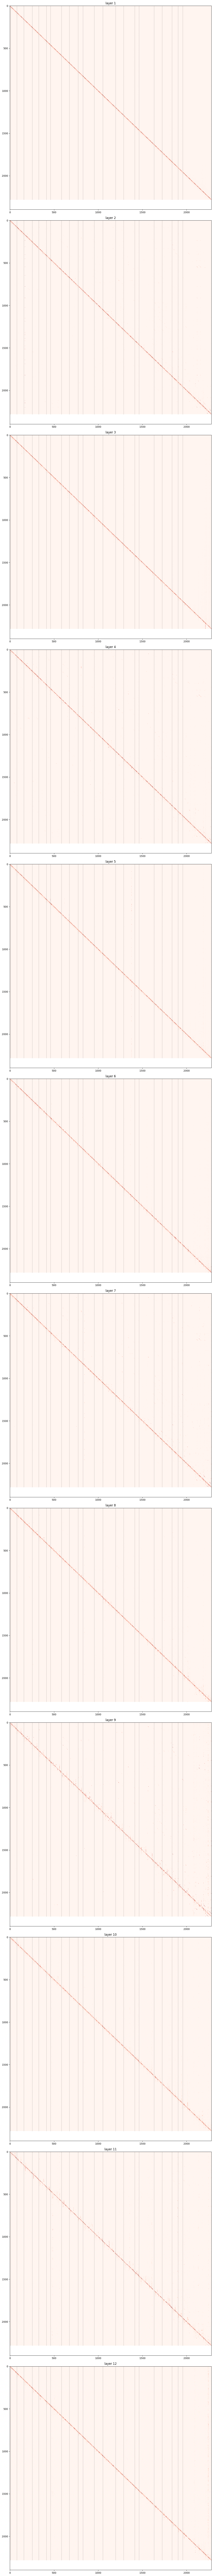

In [68]:
from matplotlib import pyplot as plt

layers = 12
example = 1

fig, axs = plt.subplots(layers, 1, figsize=(12, 12 * layers))
for layer in range(layers):
    #idx = layer * heads + head
    idx = layer
    axs[idx].set_title(f"layer {layer + 1}")
    #N = (sequences[example][segment]['attention_mask'][0] == 1).sum() + 20
    im = axs[idx].imshow(encoder_attentions[example][layer].sum(dim=0).detach().cpu().float(), 
                      vmin=0, vmax=1, cmap=plt.cm.Reds, aspect='auto', interpolation='none')
    lemmas_idxes = find_lemma_tags(list(examples[example]['state_ids'][0]))
    lemmas_idxes = [x + 1 for x in lemmas_idxes] # +1 because <a> is made of 3 tokens
    for lemma_idx in lemmas_idxes:
        axs[idx].vlines(x = lemma_idx, ymin=0, ymax=encoder_attentions[example][layer].shape[1], color = 'black', linewidths=(2,), alpha=0.1)

plt.tight_layout()
plt.show()

## Attention of RMT: only state in last seg

In [1]:
from generator.datamodule import MultipleSegmentGeneratorDataModule
from generator.model import RMTRetrievalAugmentedGenerator
import lightning_fabric.utilities.seed

lightning_fabric.utilities.seed.seed_everything(42)

num_memory_tokens = 200

2023-10-28 11:02:29.545 | DEBUG    | lean_dojo.constants:<module>:68 - Using GitHub personal access token for authentication


[2023-10-28 11:02:32,342] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


Global seed set to 42


In [2]:
data = MultipleSegmentGeneratorDataModule(
    model_name="kaiyuy/leandojo-lean3-retriever-tacgen-byt5-small",
    data_path="data/leandojo_benchmark/random/",
    corpus_path="data/leandojo_benchmark/corpus.jsonl",
    keep_marks=True,
    preds_path="pred_random.pickle",
    batch_size=1,  # effective_batch_size == batch_size * accumulate_grad_batches * devices
    eval_batch_size=1,
    max_seq_len=2300 - 2 * num_memory_tokens,
    num_segments=2,
    p_drop=0.5,
    normalize_tactics=True,
    num_workers=2,
)
data.setup()

val_dataloader = data.val_dataloader()

2023-10-28 11:02:32.836 | INFO     | common:__init__:200 - Building the corpus from data/leandojo_benchmark/corpus.jsonl
2023-10-28 11:02:44.658 | INFO     | generator.datamodule:__init__:346 - With retrieval data
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94641/94641 [00:02<00:00, 32964.82it/s]
2023-10-28 11:03:31.041 | INFO     | generator.datamodule:_load_data:68 - 207631 examples loaded
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 27136.09it/s]
2023-10-28 11:03:31.239 | INFO     | generator.datamodule:_load_data:68 - 4866 examples loaded


In [3]:
model = RMTRetrievalAugmentedGenerator.load("./leandojo_rmt/ts6m2dih/checkpoints/epoch=4-step=212628.ckpt", device="cuda",  freeze=True)

Processing zero checkpoint './leandojo_rmt/ts6m2dih/checkpoints/epoch=4-step=212628.ckpt/checkpoint'
Detected checkpoint of type zero stage 2, world_size: 1
Parsing checkpoint created by deepspeed==0.11.1
Reconstructed Frozen fp32 state dict with 111 params 217657472 elements
Reconstructed fp32 state dict with 170 params 299637760 elements
Saving fp32 state dict to /tmp/tmpj0mgecb2/lightning.cpkt


2023-10-28 11:03:42.809 | INFO     | generator.model:__init__:110 - Loading the retriever from ../leandojo-pl-ckpts/retriever_random.ckpt


Processing zero checkpoint '../leandojo-pl-ckpts/retriever_random.ckpt/checkpoint'
Detected checkpoint of type zero stage 2, world_size: 1
Parsing checkpoint created by deepspeed==0.9.2
Reconstructed fp32 state dict with 111 params 217657472 elements
Saving fp32 state dict to /tmp/tmpv8p6jsz3/lightning.cpkt


/home/nesterov-va/lean_dojo/lean_dojo_env/lib/python3.10/site-packages/pytorch_lightning/core/saving.py:161: UserWarning: Found keys that are in the model state dict but not in the checkpoint: ['encoder.encoder.embed_tokens.weight']
  rank_zero_warn(


In [23]:
example = 0

print('----SEGMENT 1----')
print(examples[example]['state'][0][0])
print('----SEGMENT 2----')
print(examples[example]['state'][1][0])
print('----TACTIC---')
print(examples[example]['tactic'][0])

----SEGMENT 1----
@[simp] lemma <a>sq_eq_sq</a> {a b : R} (ha : 0 ≤ a) (hb : 0 ≤ b) : a ^ 2 = b ^ 2 ↔ a = b

lemma <a>real_inner_div_norm_mul_norm_eq_one_iff</a> (x y : F) :
  ⟪x, y⟫_ℝ / (‖x‖ * ‖y‖) = 1 ↔ (x ≠ 0 ∧ ∃ (r : ℝ), 0 < r ∧ y = r • x)

alias <a>norm_add_sq_real</a> ← norm_add_pow_two_real

alias <a>norm_sub_sq_real</a> ← norm_sub_pow_two_real

@[simp] theorem <a>real.sqrt_inj</a> (hx : 0 ≤ x) (hy : 0 ≤ y) : sqrt x = sqrt y ↔ x = y

lemma <a>or_iff_right</a> (ha : ¬ a) : a ∨ b ↔ b

lemma <a>or_iff_left</a> (hb : ¬ b) : a ∨ b ↔ a

lemma <a>ne_comm</a> {α} {a b : α} : a ≠ b ↔ b ≠ a

lemma <a>norm_add_sq_eq_norm_sq_add_norm_sq_real</a> {x y : F} (h : ⟪x, y⟫_ℝ = 0) :
  ‖x + y‖ * ‖x + y‖ = ‖x‖ * ‖x‖ + ‖y‖ * ‖y‖

lemma <a>norm_sub_sq_eq_norm_sq_add_norm_sq_real</a> {x y : F} (h : ⟪x, y⟫_ℝ = 0) :
  ‖x - y‖ * ‖x - y‖ = ‖x‖ * ‖x‖ + ‖y‖ * ‖y‖

lemma <a>norm_sub_eq_sqrt_iff_real_inner_eq_zero</a> {x y : F} :
  ‖x - y‖ = sqrt (‖x‖ * ‖x‖ + ‖y‖ * ‖y‖) ↔ ⟪x, y⟫_ℝ = 0

lemma <a>eq_comm</a> {α 

In [17]:
examples[0]['state']

['V : Type u_1,\n_inst_1 : normed_add_comm_group V,\n_inst_3 : inner_product_space ℝ V,\n_inst_5 : fact (finrank ℝ V = 2),\no : orientation ℝ V (fin 2),\nx y : V\n⊢ x = y ↔ ‖x‖ = ‖y‖ ∧ o.oangle x y = 0']

In [11]:
# extract examples' ids
N_EXAMPLES = 8
segment = 0
examples = []

for i, t in zip(range(N_EXAMPLES), val_dataloader):
    examples.append(t)

print(len(examples))
print(examples[0].keys())
print(examples[0]['state_ids'][0].shape)
print(examples[0]['tactic_ids'].shape)

# run model to get attentions напиши здесь форвард для модели и собери аттн с разных сегментов
cross_attentions = []
#encoder_attentions = []
for ex in examples:
    ex['state_ids'] = [x.to('cuda:0') for x in ex['state_ids']]
    ex['state_mask'] = [x.to('cuda:0') for x in ex['state_mask']]
    enc_out, last_enc_mask = model._encode_with_memory(ex['state_ids'], ex['state_mask'])
    out = model.backbone.generator(
        labels=ex['tactic_ids'].to('cuda:0'),
        encoder_outputs=enc_out,
        attention_mask=last_enc_mask,
        output_attentions=True,
    )
    #encoder_attentions.append([x[0] for x in out.encoder_attentions])
    cross_attentions.append([x[0] for x in out.cross_attentions])

#print(len(encoder_attentions[0]), encoder_attentions[0][0].shape)
print(len(cross_attentions[0]), cross_attentions[0][0].shape)

8
dict_keys(['state', 'state_ids', 'state_mask', 'tactic', 'tactic_ids', 'tactic_mask', 'url', 'commit', 'file_path', 'full_name'])
torch.Size([1, 1887])
torch.Size([1, 50])
4 torch.Size([6, 50, 614])


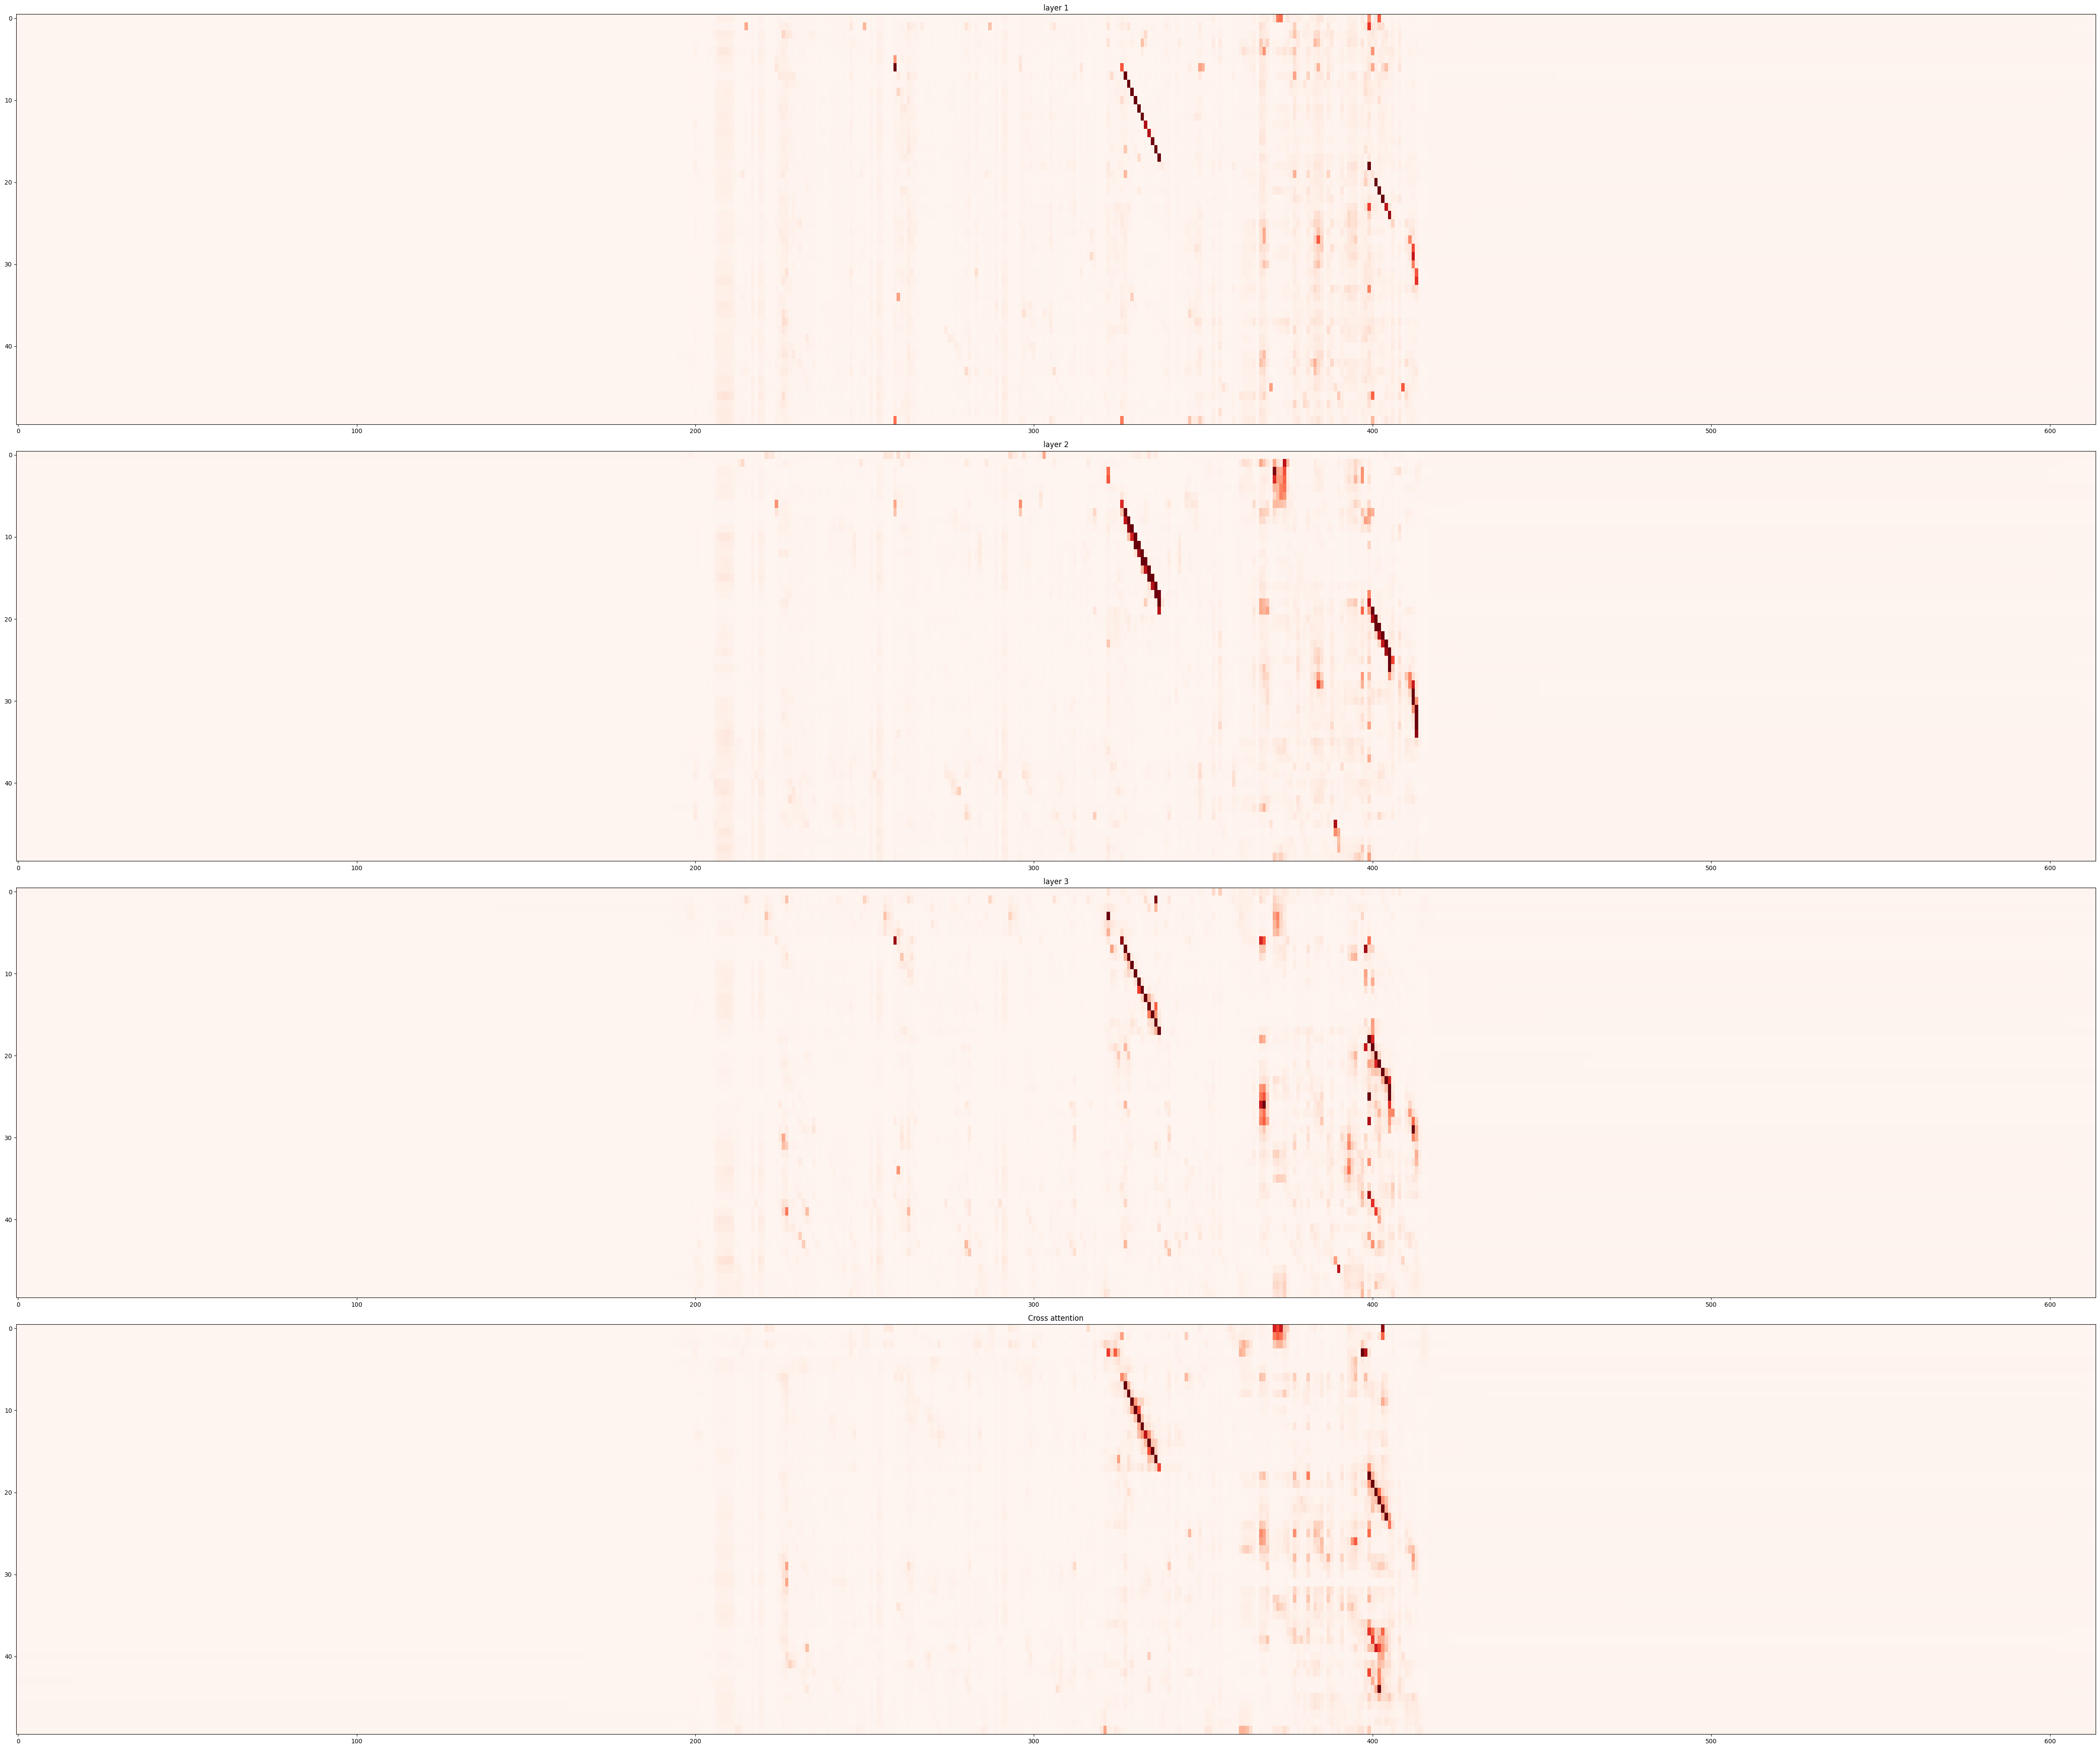

In [14]:
from matplotlib import pyplot as plt

layers = 4
example = 0

fig, axs = plt.subplots(layers, 1, figsize=(12 * layers, 40))
for layer in range(layers):
    #idx = layer * heads + head
    idx = layer
    axs[idx].set_title(f"layer {layer + 1}")
    #N = (sequences[example][segment]['attention_mask'][0] == 1).sum() + 20
    im = axs[idx].imshow(cross_attentions[example][layer].sum(dim=0).detach().cpu().float(), 
                      vmin=0, vmax=1, cmap=plt.cm.Reds, aspect='auto', interpolation='none')
    # lemmas_idxes = find_lemma_tags(list(examples[example]['state_ids'][0]))
    # lemmas_idxes = [x + 1 for x in lemmas_idxes] # +10 by memory and +2 because "<lemma>" takes 4 tokens
    # for lemma_idx in lemmas_idxes:
    #     axs[idx].vlines(x = lemma_idx, ymin=0, ymax=cross_attentions[example][layer].shape[1], color = 'black', linewidths=(2,), alpha=0.1)

plt.title("Cross attention")
plt.tight_layout()
plt.show()

## Attention of RMT: empty last seg (only memory)

In [1]:
from generator.datamodule import MultipleSegmentGeneratorDataModule
from generator.model import RMTRetrievalAugmentedGenerator
import lightning_fabric.utilities.seed

lightning_fabric.utilities.seed.seed_everything(42)

num_memory_tokens = 200

[2023-11-05 11:27:14,981] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


Global seed set to 42


In [2]:
data = MultipleSegmentGeneratorDataModule(
    model_name="kaiyuy/leandojo-lean3-retriever-tacgen-byt5-small",
    data_path="data/leandojo_benchmark/random/",
    corpus_path="data/leandojo_benchmark/corpus.jsonl",
    keep_marks=True,
    preds_path="pred_random.pickle",
    batch_size=1,  # effective_batch_size == batch_size * accumulate_grad_batches * devices
    eval_batch_size=1,
    max_seq_len=2300 - 2 * num_memory_tokens,
    num_segments=2,
    p_drop=0.5,
    normalize_tactics=True,
    num_workers=2,
)
data.setup()

val_dataloader = data.val_dataloader()

2023-11-05 11:27:15.617 | INFO     | common:__init__:200 - Building the corpus from data/leandojo_benchmark/corpus.jsonl
2023-11-05 11:27:25.451 | INFO     | generator.datamodule:__init__:357 - With retrieval data
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94641/94641 [00:02<00:00, 40712.99it/s]
2023-11-05 11:27:58.070 | INFO     | generator.datamodule:_load_data:69 - 207631 examples loaded
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 34278.11it/s]
2023-11-05 11:27:58.216 | INFO     | generator.datamodule:_load_data:69 - 4866 examples loaded


In [3]:
model = RMTRetrievalAugmentedGenerator.load("./leandojo_rmt/9mjyzeq3/checkpoints/epoch=5-step=274535.ckpt", device="cuda",  freeze=True)

Processing zero checkpoint './leandojo_rmt/9mjyzeq3/checkpoints/epoch=5-step=274535.ckpt/checkpoint'
Detected checkpoint of type zero stage 2, world_size: 1
Parsing checkpoint created by deepspeed==0.11.1
Reconstructed Frozen fp32 state dict with 111 params 217657472 elements
Reconstructed fp32 state dict with 170 params 299637760 elements
Saving fp32 state dict to /tmp/tmpwzs3qghh/lightning.cpkt


2023-11-05 11:28:06.781 | INFO     | generator.model:__init__:110 - Loading the retriever from ../leandojo-pl-ckpts/retriever_random.ckpt


Processing zero checkpoint '../leandojo-pl-ckpts/retriever_random.ckpt/checkpoint'
Detected checkpoint of type zero stage 2, world_size: 1
Parsing checkpoint created by deepspeed==0.9.2
Reconstructed fp32 state dict with 111 params 217657472 elements
Saving fp32 state dict to /tmp/tmp5fwzbj_1/lightning.cpkt


/home/nesterov-va/lean_dojo/lean_dojo_env/lib/python3.10/site-packages/pytorch_lightning/core/saving.py:161: UserWarning: Found keys that are in the model state dict but not in the checkpoint: ['encoder.encoder.embed_tokens.weight']
  rank_zero_warn(


In [23]:
# extract examples' ids
N_EXAMPLES = 40
segment = 0
examples = []

for i, t in zip(range(N_EXAMPLES), val_dataloader):
    examples.append(t)

print(len(examples))
print(examples[0].keys())
print(examples[0]['state_ids'][0].shape)
print(examples[0]['tactic_ids'].shape)

# run model to get attentions
cross_attentions = []
encoder_attentions = []
for ex in examples:
    ex['state_ids'] = [x.to('cuda:0') for x in ex['state_ids']]
    ex['state_mask'] = [x.to('cuda:0') for x in ex['state_mask']]
    out = model(
        state_ids=ex['state_ids'],
        state_mask=ex['state_mask'],
        tactic_ids=ex['tactic_ids'].to('cuda:0'),
        output_attentions=True,
    )
    encoder_attentions.append([[x[0].detach().cpu() for x in y] for y in out.encoder_attentions])
    cross_attentions.append([x[0].detach().cpu() for x in out.cross_attentions])

print("encoder shapes:", len(encoder_attentions), len(encoder_attentions[0]), len(encoder_attentions[0][0]), encoder_attentions[0][0][0].shape)
print("cross shapes:", len(cross_attentions), len(cross_attentions[0]), cross_attentions[0][0].shape)

41
dict_keys(['state', 'state_ids', 'state_mask', 'tactic', 'tactic_ids', 'tactic_mask', 'url', 'commit', 'file_path', 'full_name'])
torch.Size([1, 1881])
torch.Size([1, 50])
encoder shapes: 41 2 12 torch.Size([6, 2281, 2281])
cross shapes: 41 4 torch.Size([6, 50, 2287])


In [30]:
example = 20

print('----SEGMENT 1----')
print(examples[example]['state'][0][0])
print('----SEGMENT 2----')
print(examples[example]['state'][1][0])
print('----TACTIC---')
print(examples[example]['tactic'][0])

----SEGMENT 1----
lemma <a>div_neg</a> (a : K) : a / -b = -(a / b)

lemma <a>neg_div</a> (a b : K) : (-b) / a = - (b / a)

lemma <a>neg_div_neg_eq</a> (a b : K) : (-a) / (-b) = a / b

lemma <a>sign_apply</a> : sign a = ite (0 < a) 1 (ite (a < 0) (-1) 0)

@[simp] theorem <a>smul_neg</a> (r : M) (x : A) : r • (-x) = -(r • x)

@[simp, to_additive] lemma <a>inv_div</a> : (a / b)⁻¹ = b / a

@[simp] theorem <a>neg_smul</a> : -r • x = - (r • x)

theorem <a>int.sign_eq_one_of_pos</a> {a : ℤ} (h : 0 < a) : sign a = 1

@[simp] lemma <a>orientation.oangle_sign_smul_right</a> (x y : V) (r : ℝ) :
  (o.oangle x (r • y)).sign = sign r * (o.oangle x y).sign

theorem <a>int.sign_mul_abs</a> (a : ℤ) : sign a * |a| = a

@[to_additive "Subtracting an element is the same as adding by its negative.

This is a duplicate of `sub_neg_monoid.sub_eq_mul_neg` ensuring that the types unfold better."]
lemma <a>div_eq_mul_inv</a> (a b : G) : a / b = a * b⁻¹

theorem <a>int.sign_eq_neg_one_of_neg</a> {a : ℤ} (h : a <

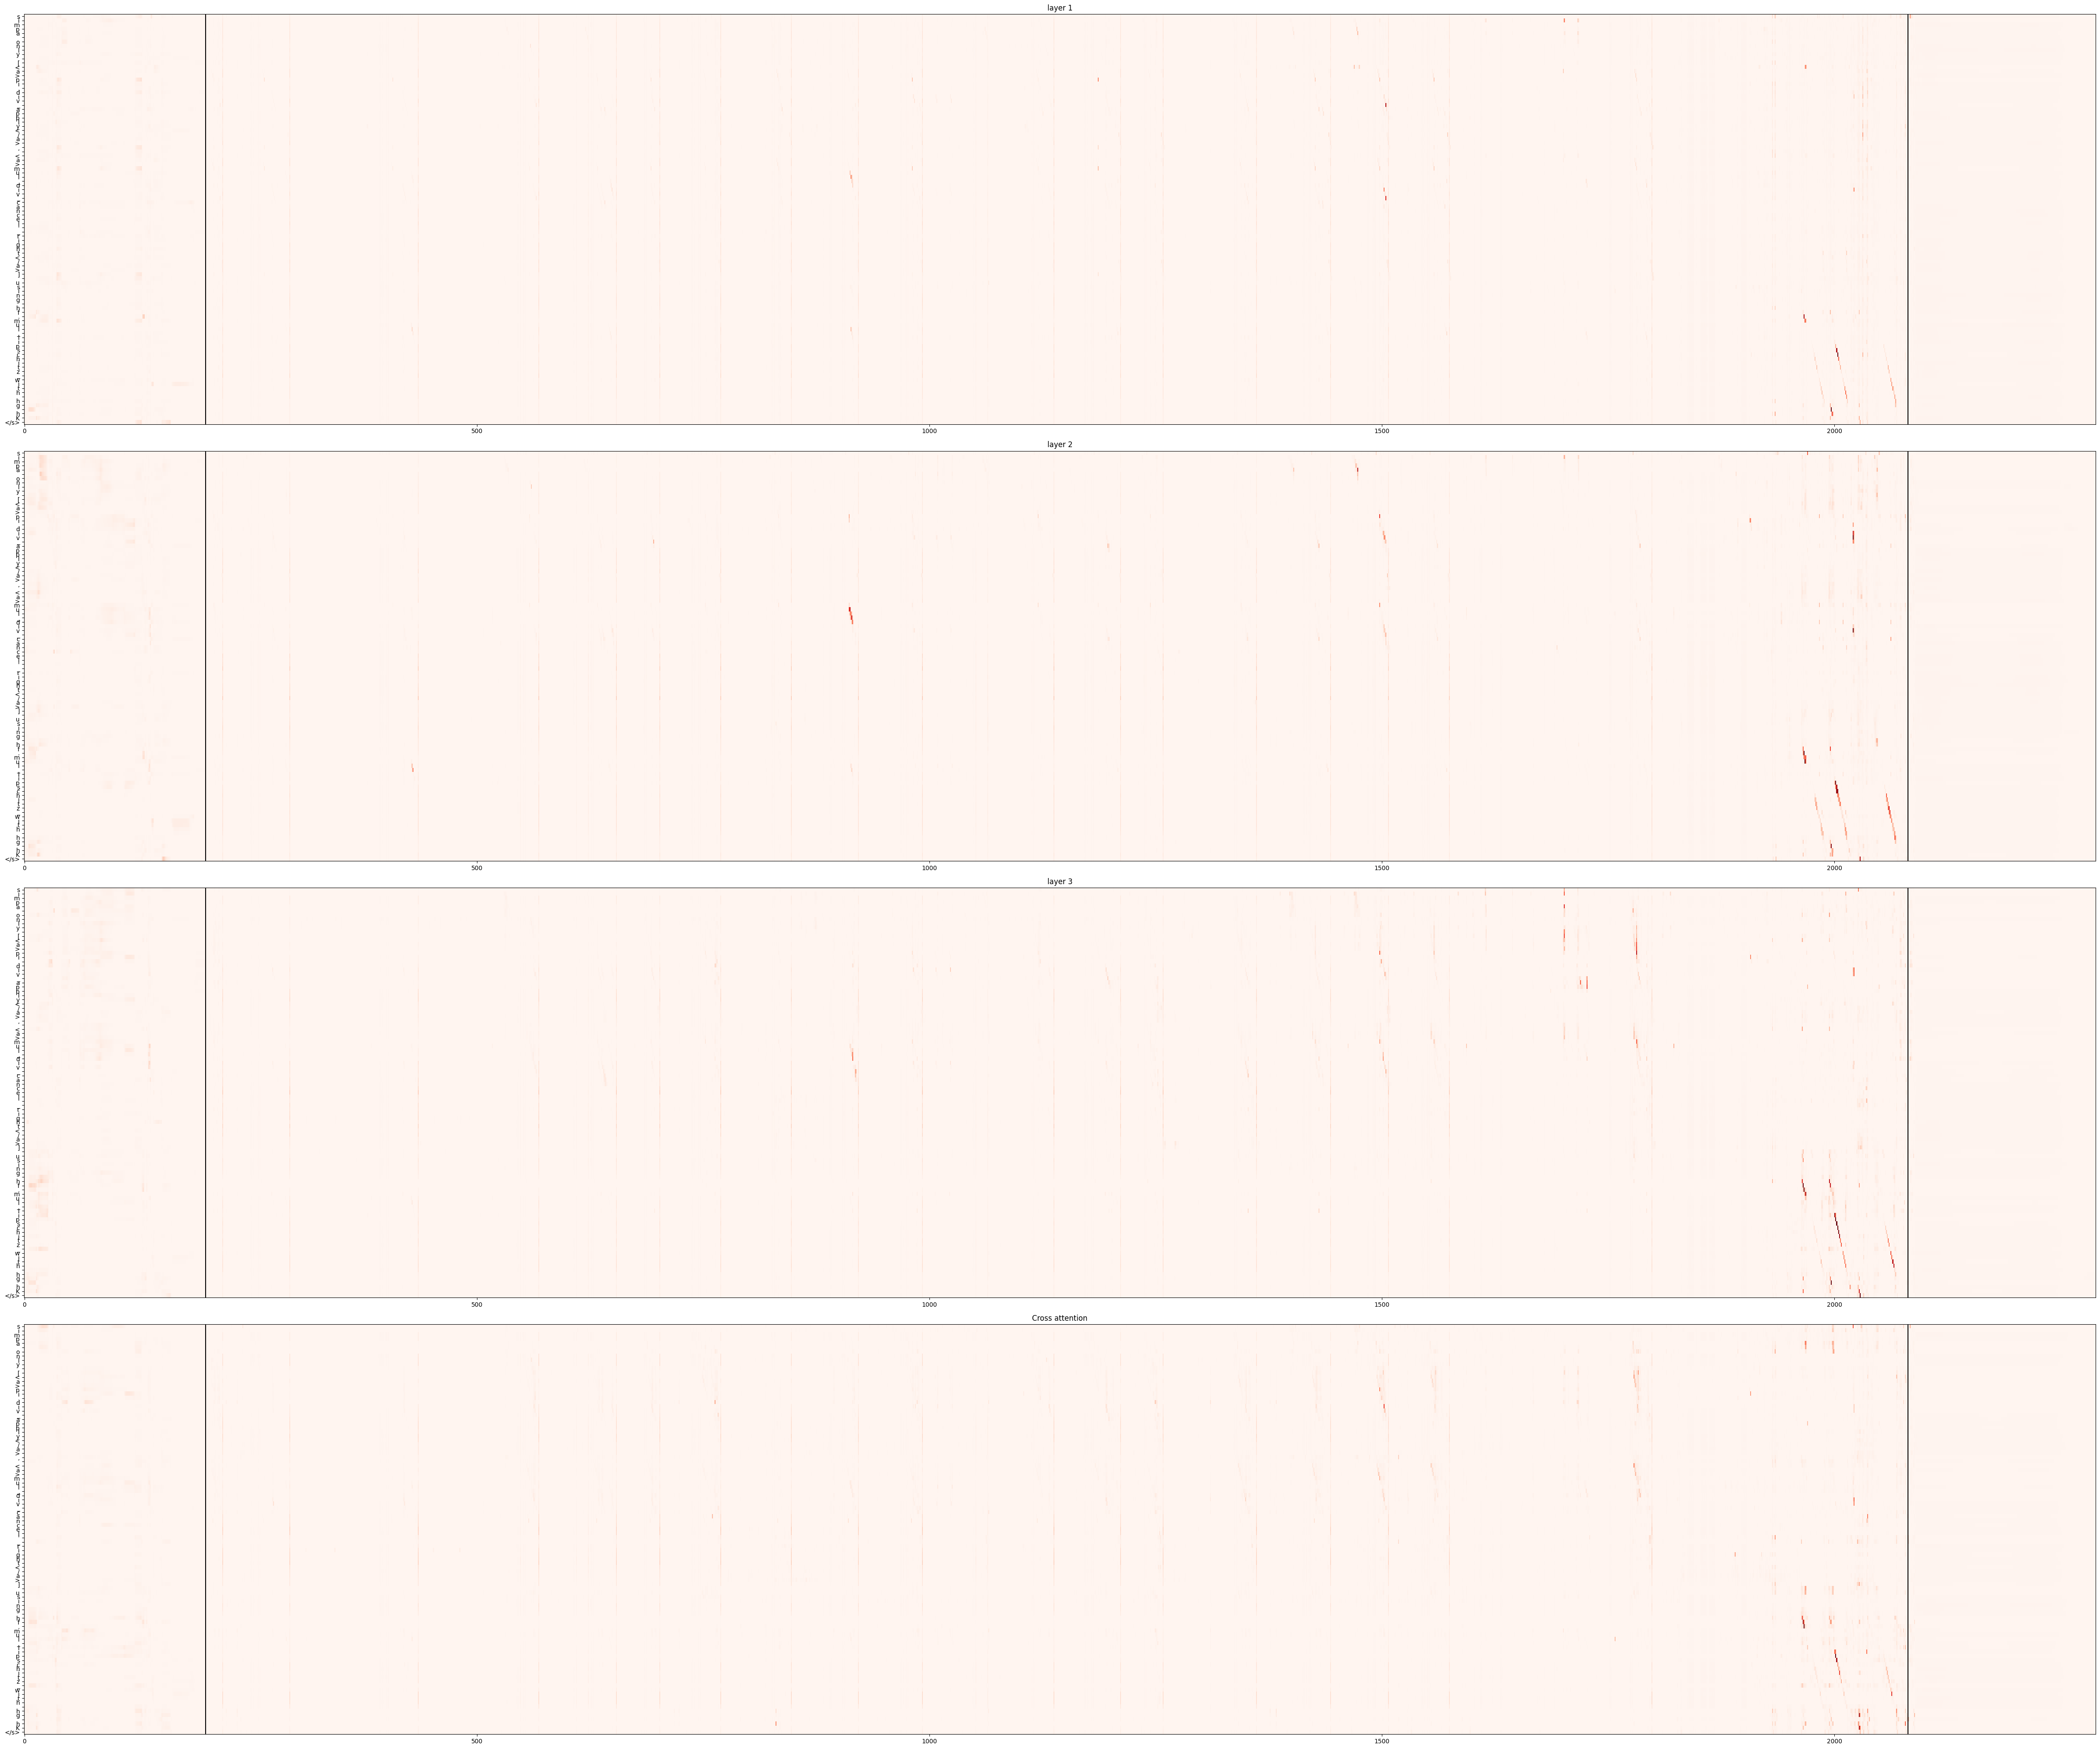

In [28]:
from matplotlib import pyplot as plt
import numpy as np

layers = 4
example = 18

fig, axs = plt.subplots(layers, 1, figsize=(12 * layers, 40))
for layer in range(layers):
    #idx = layer * heads + head
    idx = layer
    axs[idx].set_title(f"layer {layer + 1}")
    #N = (sequences[example][segment]['attention_mask'][0] == 1).sum() + 20
    im = axs[idx].imshow(cross_attentions[example][layer].sum(dim=0).detach().cpu().float(), 
                      vmin=0, vmax=1, cmap=plt.cm.Reds, aspect='auto', interpolation='none')
    tokens = [model.tokenizer.decode(examples[example]['tactic_ids'][0][x]) for x in range(cross_attentions[example][layer].sum(dim=0).shape[0])]
    axs[idx].set_yticks(np.arange(len(tokens)), tokens)
    axs[idx].axvline(x=num_memory_tokens, color = 'black')
    axs[idx].axvline(x=data.shape[0] - num_memory_tokens, color='black')
    # lemmas_idxes = find_lemma_tags(list(examples[example]['state_ids'][0]))
    # lemmas_idxes = [x + 1 for x in lemmas_idxes] # +10 by memory and +2 because "<lemma>" takes 4 tokens
    # for lemma_idx in lemmas_idxes:
    #     axs[idx].vlines(x = lemma_idx, ymin=0, ymax=cross_attentions[example][layer].shape[1], color = 'black', linewidths=(2,), alpha=0.1)

plt.title("Cross attention")
plt.tight_layout()
plt.savefig("cross_attentions.png")
plt.show()

In [13]:
from matplotlib import pyplot as plt
import numpy as np

layers = list(range(12))
#layers = [0, 1]
example = 0
segment = 0

fig, axs = plt.subplots(len(layers), 1, figsize=(40, 40 * len(layers)))
for idx, layer in enumerate(layers):
    #idx = layer * heads + head
    axs[idx].set_title(f"layer {layer + 1}")
    #N = (sequences[example][segment]['attention_mask'][0] == 1).sum() + 20
    data = encoder_attentions[example][segment][layer].sum(dim=0).detach().cpu().float()
    im = axs[idx].imshow(data, vmin=0, vmax=1, cmap=plt.cm.Reds, aspect='auto', interpolation='none')
    axs[idx].axvline(x=num_memory_tokens, color = 'black')
    axs[idx].axvline(x=data.shape[0] - num_memory_tokens, color='black')
    axs[idx].axhline(y=num_memory_tokens, color='black')
    axs[idx].axhline(y=data.shape[1] - num_memory_tokens, color='black')
    #axs[idx].hlines(y=[num_memory_tokens, data.shape[1] - num_memory_tokens], xmin=0, xmax=data.shape[0], color='black')
    #tokens = [model.tokenizer.decode(examples[example]['tactic_ids'][0][x]) for x in range(data.shape[0])]
    #axs[idx].set_yticks(np.arange(len(tokens)), tokens)
    # lemmas_idxes = find_lemma_tags(list(examples[example]['state_ids'][0]))
    # lemmas_idxes = [x + 1 for x in lemmas_idxes] # +10 by memory and +2 because "<lemma>" takes 4 tokens
    # for lemma_idx in lemmas_idxes:
    #     axs[idx].vlines(x = lemma_idx, ymin=0, ymax=cross_attentions[example][layer].shape[1], color = 'black', linewidths=(2,), alpha=0.1)

plt.title("Encoder attentions")
plt.tight_layout()
plt.savefig("encoder_attention.png")
plt.close()

## RMT generation

In [1]:
from generator.datamodule import MultipleSegmentGeneratorDataModule
from generator.model import RMTRetrievalAugmentedGenerator
import lightning_fabric.utilities.seed

lightning_fabric.utilities.seed.seed_everything(42)

num_memory_tokens = 200

2023-11-12 12:15:40.697 | DEBUG    | lean_dojo.constants:<module>:68 - Using GitHub personal access token for authentication


[2023-11-12 12:15:43,909] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


Global seed set to 42


In [2]:
data = MultipleSegmentGeneratorDataModule(
    model_name="kaiyuy/leandojo-lean3-retriever-tacgen-byt5-small",
    data_path="data/leandojo_benchmark/random/",
    corpus_path="data/leandojo_benchmark/corpus.jsonl",
    keep_marks=True,
    preds_path="pred_random.pickle",
    batch_size=1,  # effective_batch_size == batch_size * accumulate_grad_batches * devices
    eval_batch_size=1,
    max_seq_len=2300 - 2 * num_memory_tokens,
    num_segments=2,
    p_drop=0.5,
    normalize_tactics=True,
    num_workers=2,
)
data.setup()

val_dataloader = data.val_dataloader()

2023-11-12 12:15:44.285 | INFO     | common:__init__:200 - Building the corpus from data/leandojo_benchmark/corpus.jsonl
2023-11-12 12:15:55.385 | INFO     | generator.datamodule:__init__:357 - With retrieval data
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 94641/94641 [00:02<00:00, 33736.09it/s]
2023-11-12 12:16:38.839 | INFO     | generator.datamodule:_load_data:69 - 207631 examples loaded
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 28525.40it/s]
2023-11-12 12:16:39.022 | INFO     | generator.datamodule:_load_data:69 - 4866 examples loaded


In [3]:
model = RMTRetrievalAugmentedGenerator.load("./checkpoints/last.ckpt/", device="cuda",  freeze=True)

Processing zero checkpoint './checkpoints/last.ckpt/checkpoint'
Detected checkpoint of type zero stage 2, world_size: 1
Parsing checkpoint created by deepspeed==0.11.1
Reconstructed Frozen fp32 state dict with 111 params 217657472 elements
Reconstructed fp32 state dict with 170 params 299637760 elements
Saving fp32 state dict to /tmp/tmpmrwfuwkb/lightning.cpkt


2023-11-12 12:16:49.130 | INFO     | generator.model:__init__:110 - Loading the retriever from ../leandojo-pl-ckpts/retriever_random.ckpt


Processing zero checkpoint '../leandojo-pl-ckpts/retriever_random.ckpt/checkpoint'
Detected checkpoint of type zero stage 2, world_size: 1
Parsing checkpoint created by deepspeed==0.9.2
Reconstructed fp32 state dict with 111 params 217657472 elements
Saving fp32 state dict to /tmp/tmpajqkx_h8/lightning.cpkt


/home/nesterov-va/lean_dojo/lean_dojo_env/lib/python3.10/site-packages/pytorch_lightning/core/saving.py:161: UserWarning: Found keys that are in the model state dict but not in the checkpoint: ['encoder.encoder.embed_tokens.weight']
  rank_zero_warn(


In [4]:
N_EXAMPLES = 40
states = []

for i in range(N_EXAMPLES):
    states.append(data.ds_val[i]['state'][-1].split('\n\n')[-1])

In [5]:
print(states[12])

V : Type u_1,
_inst_1 : normed_add_comm_group V,
_inst_3 : inner_product_space ℝ V,
_inst_5 : fact (finrank ℝ V = 2),
o : orientation ℝ V (fin 2),
y : V,
hy : y ≠ 0,
r : ℝ,
hr : 0 ≤ r,
h₁ : ‖r • y‖ = ‖y‖,
h₂ : same_ray ℝ (r • y) y,
this : ‖y‖ ≠ 0
⊢ r * ‖y‖ = 1 * ‖y‖


In [8]:
model.backbone.retriever.load_corpus(data.corpus)

In [9]:
idx = 12
model.generate(states[idx], data.ds_val[idx]['file_path'], data.ds_val[idx]['full_name'], theorem_pos=0, num_samples=4)

2023-11-12 12:45:00.251 | DEBUG    | generator.model:batch_generate:641 - ['V : Type u_1,\n_inst_1 : normed_add_comm_group V,\n_inst_3 : inner_product_space ℝ V,\n_inst_5 : fact (finrank ℝ V = 2),\no : orientation ℝ V (fin 2),\ny : V,\nhy : y ≠ 0,\nr : ℝ,\nhr : 0 ≤ r,\nh₁ : ‖r • y‖ = ‖y‖,\nh₂ : same_ray ℝ (r • y) y,\nthis : ‖y‖ ≠ 0\n⊢ r * ‖y‖ = 1 * ‖y‖']
2023-11-12 12:45:00.255 | INFO     | retrieval.model:reindex_corpus:172 - Re-indexing the retrieval corpus
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4068/4068 [18:29<00:00,  3.67it/s]


AssertionError: 

### Change seq len in checkpoint

In [18]:
import pytorch_lightning as pl
from generator.model import RetrievalAugmentedGenerator
import torch

In [20]:
checkpoint = torch.load('/home/vasa/lean_dojo/leandojo-pl-ckpts/generator_random.ckpt/checkpoint/mp_rank_00_model_states.pt')

In [29]:
checkpoint['hyper_parameters']['max_seq_len'] = 500

In [30]:
torch.save(checkpoint, './to_valid/ld_500_mp_rank_00_model_states.pt')

500